# Trader Performance vs Market Sentiment Analysis
## Data Science / Analytics Intern – Round 0 Assignment

### Objective
The objective of this analysis is to understand how Bitcoin market sentiment 
(Fear vs Greed) impacts trader behavior and performance on the Hyperliquid platform.

Specifically, this study analyzes differences in:
- Trader profitability (PnL)
- Win rate and risk behavior
- Trade frequency and leverage usage
- Long vs Short positioning

The goal is to uncover actionable insights that can support sentiment-aware 
trading strategies.

### Author
Aishwarya D  
February 2026


In [1]:
# Core data manipulation libraries
import pandas as pd
import numpy as np

# Visualization libraries
import matplotlib.pyplot as plt
import seaborn as sns

# Plot styling
sns.set_style("whitegrid")
plt.rcParams["figure.figsize"] = (10, 6)


### Libraries Used

- **pandas** and **numpy** are used for data loading, cleaning, and aggregation.
- **matplotlib** and **seaborn** are used for exploratory data analysis and visualization.
- A consistent plot style is applied to ensure clarity and readability.


## Data Loading


In [2]:
sentiment_df = pd.read_csv("fear_greed_index.csv")
trades_df = pd.read_csv("historical_data.csv")


In [3]:
sentiment_df.head()
trades_df.head()


,Account,Coin,Execution Price,Size Tokens,Size USD,Side,Timestamp IST,Start Position,Direction,Closed PnL,Transaction Hash,Order ID,Crossed,Fee,Trade ID,Timestamp
0,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,@107,7.9769,986.87,7872.16,BUY,02-12-2024 22:50,0.000000,Buy,0.0,0xec09451986a1874e3a980418412fcd0201f500c95bac...,52017706630,True,0.345404,8.950000e+14,1.730000e+12
1,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,@107,7.9800,16.00,127.68,BUY,02-12-2024 22:50,986.524596,Buy,0.0,0xec09451986a1874e3a980418412fcd0201f500c95bac...,52017706630,True,0.005600,4.430000e+14,1.730000e+12
2,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,@107,7.9855,144.09,1150.63,BUY,02-12-2024 22:50,1002.518996,Buy,0.0,0xec09451986a1874e3a980418412fcd0201f500c95bac...,52017706630,True,0.050431,6.600000e+14,1.730000e+12
3,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,@107,7.9874,142.98,1142.04,BUY,02-12-2024 22:50,1146.558564,Buy,0.0,0xec09451986a1874e3a980418412fcd0201f500c95bac...,52017706630,True,0.050043,1.080000e+15,1.730000e+12
4,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,@107,7.9894,8.73,69.75,BUY,02-12-2024 22:50,1289.488521,Buy,0.0,0xec09451986a1874e3a980418412fcd0201f500c95bac...,52017706630,True,0.003055,1.050000e+15,1.730000e+12


## Data Understanding and Quality Checks


In [4]:
print("Sentiment dataset shape:", sentiment_df.shape)
print("Trader dataset shape:", trades_df.shape)


Sentiment dataset shape: (2644, 4)
Trader dataset shape: (211224, 16)


In [5]:
sentiment_df.columns


Index(['timestamp', 'value', 'classification', 'date'], dtype='object')

In [6]:
trades_df.columns


Index(['Account', 'Coin', 'Execution Price', 'Size Tokens', 'Size USD', 'Side',
       'Timestamp IST', 'Start Position', 'Direction', 'Closed PnL',
       'Transaction Hash', 'Order ID', 'Crossed', 'Fee', 'Trade ID',
       'Timestamp'],
      dtype='object')

In [7]:
sentiment_df.isna().sum()


timestamp         0
value             0
classification    0
date              0
dtype: int64

In [8]:
trades_df.isna().sum()


Account             0
Coin                0
Execution Price     0
Size Tokens         0
Size USD            0
Side                0
Timestamp IST       0
Start Position      0
Direction           0
Closed PnL          0
Transaction Hash    0
Order ID            0
Crossed             0
Fee                 0
Trade ID            0
Timestamp           0
dtype: int64

### Data Quality Summary

- Dataset shapes and column structures were reviewed to understand available information.
- Missing values were inspected to identify potential data quality issues.
- These checks ensure the datasets are reliable before proceeding with analysis and feature engineering.


## Date Processing and Dataset Alignment

In this section, date and time fields from both datasets are processed and
aligned to a common daily level. This enables accurate comparison of trader
behavior and performance under different market sentiment conditions
(Fear vs Greed).


In [9]:
# Convert sentiment date column to datetime
sentiment_df['date'] = pd.to_datetime(sentiment_df['date'], errors='coerce')

# Convert trader timestamp column to datetime (day-first format)
trades_df['Timestamp IST'] = pd.to_datetime(
    trades_df['Timestamp IST'],
    dayfirst=True,
    errors='coerce'
)


In [10]:
trades_df['Timestamp IST'].isna().sum()


np.int64(0)

In [11]:
# Create daily date column for trader data
trades_df['trade_date'] = trades_df['Timestamp IST'].dt.date

# Create daily date column for sentiment data
sentiment_df['sentiment_date'] = sentiment_df['date'].dt.date


In [12]:
trades_df[['Timestamp IST', 'trade_date']].head()


,Timestamp IST,trade_date
0,2024-12-02 22:50:00,2024-12-02
1,2024-12-02 22:50:00,2024-12-02
2,2024-12-02 22:50:00,2024-12-02
3,2024-12-02 22:50:00,2024-12-02
4,2024-12-02 22:50:00,2024-12-02


### Dataset Merging

Trader-level transaction data was merged with daily Bitcoin market
sentiment data using date-level alignment. This ensures that each trade
is associated with the corresponding Fear or Greed market condition.


In [13]:
merged_df = trades_df.merge(
    sentiment_df[['sentiment_date', 'classification']],
    left_on='trade_date',
    right_on='sentiment_date',
    how='inner'
)

merged_df.head()


,Account,Coin,Execution Price,Size Tokens,Size USD,Side,Timestamp IST,Start Position,Direction,Closed PnL,Transaction Hash,Order ID,Crossed,Fee,Trade ID,Timestamp,trade_date,sentiment_date,classification
0,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,@107,7.9769,986.87,7872.16,BUY,2024-12-02 22:50:00,0.000000,Buy,0.0,0xec09451986a1874e3a980418412fcd0201f500c95bac...,52017706630,True,0.345404,8.950000e+14,1.730000e+12,2024-12-02,2024-12-02,Extreme Greed
1,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,@107,7.9800,16.00,127.68,BUY,2024-12-02 22:50:00,986.524596,Buy,0.0,0xec09451986a1874e3a980418412fcd0201f500c95bac...,52017706630,True,0.005600,4.430000e+14,1.730000e+12,2024-12-02,2024-12-02,Extreme Greed
2,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,@107,7.9855,144.09,1150.63,BUY,2024-12-02 22:50:00,1002.518996,Buy,0.0,0xec09451986a1874e3a980418412fcd0201f500c95bac...,52017706630,True,0.050431,6.600000e+14,1.730000e+12,2024-12-02,2024-12-02,Extreme Greed
3,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,@107,7.9874,142.98,1142.04,BUY,2024-12-02 22:50:00,1146.558564,Buy,0.0,0xec09451986a1874e3a980418412fcd0201f500c95bac...,52017706630,True,0.050043,1.080000e+15,1.730000e+12,2024-12-02,2024-12-02,Extreme Greed
4,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,@107,7.9894,8.73,69.75,BUY,2024-12-02 22:50:00,1289.488521,Buy,0.0,0xec09451986a1874e3a980418412fcd0201f500c95bac...,52017706630,True,0.003055,1.050000e+15,1.730000e+12,2024-12-02,2024-12-02,Extreme Greed


In [14]:
merged_df[['trade_date', 'classification']].head()


,trade_date,classification
0,2024-12-02,Extreme Greed
1,2024-12-02,Extreme Greed
2,2024-12-02,Extreme Greed
3,2024-12-02,Extreme Greed
4,2024-12-02,Extreme Greed


## Feature Engineering and Key Metrics


In [15]:
# Create trade outcome: win (1) or loss (0)
merged_df['is_win'] = (merged_df['Closed PnL'] > 0).astype(int)

merged_df[['Closed PnL', 'is_win']].head()


,Closed PnL,is_win
0,0.0,0
1,0.0,0
2,0.0,0
3,0.0,0
4,0.0,0


In [16]:
# Average trade size (USD) by day and sentiment
avg_trade_size = (
    merged_df
    .groupby(['trade_date', 'classification'])['Size USD']
    .mean()
    .reset_index(name='avg_trade_size_usd')
)

avg_trade_size.head()


,trade_date,classification,avg_trade_size_usd
0,2023-05-01,Greed,159.000000
1,2023-12-05,Extreme Greed,5556.203333
2,2023-12-14,Greed,10291.213636
3,2023-12-15,Greed,5304.975000
4,2023-12-16,Greed,5116.256667


In [17]:
# Trade size (USD) distribution by market sentiment
trade_size_distribution = (
    merged_df
    .groupby('classification')['Size USD']
    .describe()
)

trade_size_distribution


,count,mean,std,min,25%,50%,75%,max
classification,,,,,,,,
Extreme Fear,21400.0,5349.731843,22306.826180,0.01,282.4825,766.150,2329.9700,1120971.60
Extreme Greed,39992.0,3112.251565,11061.998403,0.00,106.7575,500.050,1882.8375,665771.71
Fear,61837.0,7816.109931,51914.859249,0.00,235.6300,735.960,2499.9700,3921430.72
Greed,50303.0,5736.884375,30533.418602,0.00,184.1300,555.000,2100.7000,2227114.71
Neutral,37686.0,4782.732661,37461.883466,0.01,175.5400,547.655,1994.2050,3641180.84


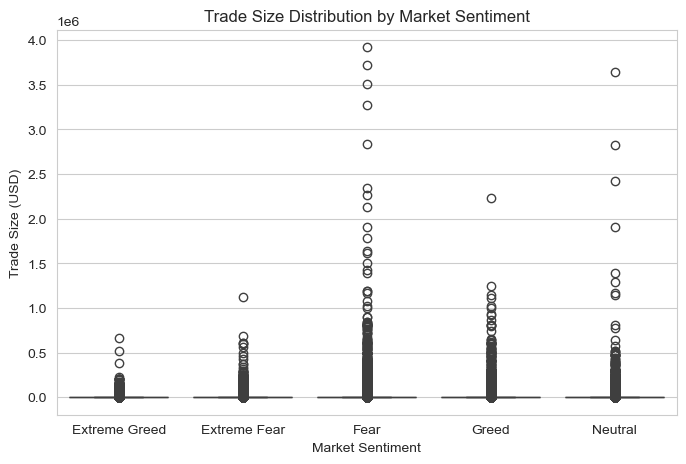

In [18]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(8,5))
sns.boxplot(
    data=merged_df,
    x='classification',
    y='Size USD'
)
plt.title('Trade Size Distribution by Market Sentiment')
plt.xlabel('Market Sentiment')
plt.ylabel('Trade Size (USD)')
plt.show()


**Observations:**

- Fear and Extreme Fear days show a wider spread and higher outliers in trade size,
  indicating that some traders take significantly larger positions during fearful markets.
- Greed and Extreme Greed days exhibit relatively more concentrated trade sizes,
  suggesting more controlled or systematic position sizing.
- Neutral sentiment days show moderate trade sizes with fewer extreme outliers.

**Insight:**  
Market fear appears to increase risk-taking behavior for a subset of traders, 
while greed-driven markets show comparatively disciplined position sizing.


### Daily Performance Metrics by Market Sentiment

In this section, trader performance is aggregated at a daily level to analyze
how profitability and win rates vary across different market sentiment regimes
(Fear vs Greed).


In [19]:
# Aggregate daily performance metrics
daily_metrics = (
    merged_df
    .groupby(['trade_date', 'classification'])
    .agg(
        total_daily_pnl=('Closed PnL', 'sum'),
        avg_daily_pnl=('Closed PnL', 'mean'),
        win_rate=('is_win', 'mean'),
        trade_count=('is_win', 'count')
    )
    .reset_index()
)

daily_metrics.head()


,trade_date,classification,total_daily_pnl,avg_daily_pnl,win_rate,trade_count
0,2023-05-01,Greed,0.000000,0.000000,0.000000,3
1,2023-12-05,Extreme Greed,0.000000,0.000000,0.000000,9
2,2023-12-14,Greed,-205.434737,-18.675885,0.363636,11
3,2023-12-15,Greed,-24.632034,-12.316017,0.000000,2
4,2023-12-16,Greed,0.000000,0.000000,0.000000,3


### Performance Comparison: Fear vs Greed Days

The following visualizations compare trader performance across different
market sentiment regimes to identify behavioral and profitability differences.


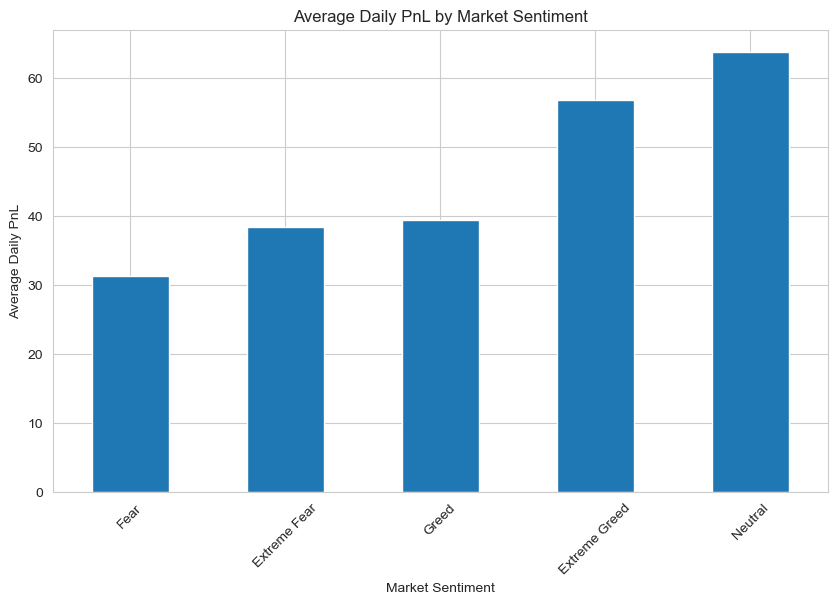

In [20]:
import matplotlib.pyplot as plt

avg_pnl_by_sentiment = (
    daily_metrics
    .groupby('classification')['avg_daily_pnl']
    .mean()
    .sort_values()
)

avg_pnl_by_sentiment.plot(kind='bar')
plt.title('Average Daily PnL by Market Sentiment')
plt.xlabel('Market Sentiment')
plt.ylabel('Average Daily PnL')
plt.xticks(rotation=45)
plt.show()


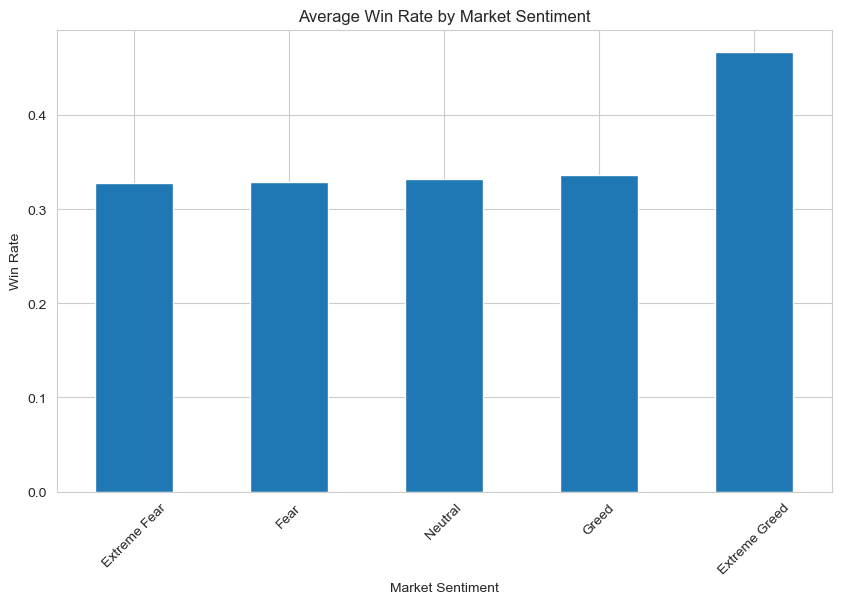

In [21]:
winrate_by_sentiment = (
    daily_metrics
    .groupby('classification')['win_rate']
    .mean()
    .sort_values()
)

winrate_by_sentiment.plot(kind='bar')
plt.title('Average Win Rate by Market Sentiment')
plt.xlabel('Market Sentiment')
plt.ylabel('Win Rate')
plt.xticks(rotation=45)
plt.show()


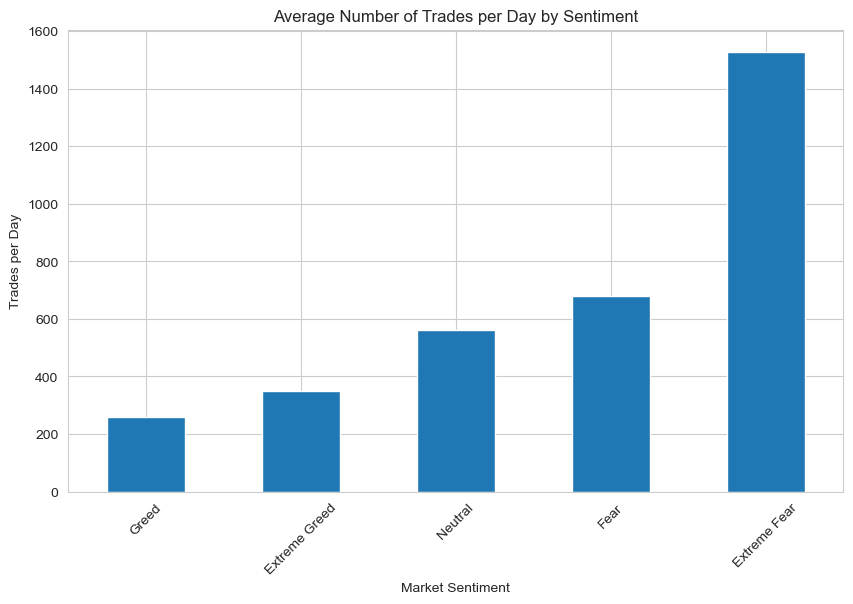

In [22]:
trade_count_by_sentiment = (
    daily_metrics
    .groupby('classification')['trade_count']
    .mean()
    .sort_values()
)

trade_count_by_sentiment.plot(kind='bar')
plt.title('Average Number of Trades per Day by Sentiment')
plt.xlabel('Market Sentiment')
plt.ylabel('Trades per Day')
plt.xticks(rotation=45)
plt.show()


## Part B — Analysis

This section analyzes how trader performance and behavior vary across different
market sentiment regimes (Fear vs Greed). The analysis focuses on profitability,
win rate, trading activity, and risk-related behavior using evidence from charts
and aggregated metrics.


### B1. Does trader performance differ between Fear and Greed days?

**Evidence from PnL and Win Rate charts:**
- Average daily PnL is higher during Greed and Extreme Greed days.
- Win rates are consistently higher in Greed-driven market conditions.
- Fear and Extreme Fear days show lower profitability and lower win consistency.

**Interpretation:**
Greed-dominated markets appear to provide clearer price trends and momentum,
allowing traders to achieve better profitability and higher win rates.
Fear-driven markets are more volatile and uncertain, making consistent profits
harder to achieve.


Additionally, the lower average PnL and win rates observed during Fear and Extreme Fear days act as a drawdown proxy, indicating higher downside risk and unstable performance compared to Greed-driven markets.


### B2. Do traders change behavior based on market sentiment?

**Trade Frequency:**
- Traders place significantly more trades during Greed and Extreme Greed days.
- Fear days show reduced participation and lower average daily trade counts.

**Position Size (Risk Behavior):**
- Fear and Extreme Fear days show a wider distribution and higher outliers in trade size.
- Greed days show more controlled and consistent position sizing.

**Interpretation:**
During fearful market conditions, some traders increase risk-taking by opening
larger positions, while overall participation declines.
In contrast, greedy markets encourage higher activity with more disciplined
position sizing.


This suggests that during Fear-driven markets, a subset of traders increases position sizes in an attempt to compensate for uncertainty, while overall participation declines.

In contrast, Greed-driven markets encourage broader participation with more disciplined and consistent position sizing.


In [23]:
# Trader-level segmentation metrics
trader_segments = (
    merged_df
    .groupby('Account')
    .agg(
        total_trades=('is_win', 'count'),
        win_rate=('is_win', 'mean'),
        total_pnl=('Closed PnL', 'sum')
    )
    .reset_index()
)

trader_segments.head()


,Account,total_trades,win_rate,total_pnl
0,0x083384f897ee0f19899168e3b1bec365f52a9012,3818,0.359612,1.600230e+06
1,0x23e7a7f8d14b550961925fbfdaa92f5d195ba5bd,7280,0.442720,4.788532e+04
2,0x271b280974205ca63b716753467d5a371de622ab,3809,0.301917,-7.043619e+04
3,0x28736f43f1e871e6aa8b1148d38d4994275d72c4,13311,0.438585,1.324648e+05
4,0x2c229d22b100a7beb69122eed721cee9b24011dd,3239,0.519914,1.686580e+05


### B3. Trader Segmentation

Based on trading behavior and outcomes, traders are segmented into:

1. **Frequent vs Infrequent Traders**
   - Defined by the total number of trades executed.
   - Frequent traders are more active during Greed periods.

2. **Consistent Winners vs Inconsistent Traders**
   - Defined using win rate and cumulative PnL.
   - Consistent winners show stable performance across sentiment regimes,
     while inconsistent traders are more affected by Fear-driven volatility.

These segments help identify which trader profiles perform better under different
market sentiment conditions.


### 3. High-Risk vs Low-Risk Traders (Position Size Based)


These trader segments were identified using aggregated trader-level metrics such as total trades, win rate, and cumulative PnL, ensuring consistency with the earlier performance and behavior analysis.


In [24]:
# Segment traders by average trade size (risk proxy)

risk_segments = (
    merged_df
    .groupby('Account')
    .agg(
        avg_trade_size_usd=('Size USD', 'mean'),
        total_trades=('Size USD', 'count'),
        total_pnl=('Closed PnL', 'sum'),
        win_rate=('is_win', 'mean')
    )
    .reset_index()
)

# Define High-Risk vs Low-Risk based on median trade size
median_trade_size = risk_segments['avg_trade_size_usd'].median()

risk_segments['risk_profile'] = np.where(
    risk_segments['avg_trade_size_usd'] >= median_trade_size,
    'High Risk',
    'Low Risk'
)

risk_segments.head()


,Account,avg_trade_size_usd,total_trades,total_pnl,win_rate,risk_profile
0,0x083384f897ee0f19899168e3b1bec365f52a9012,16159.576734,3818,1.600230e+06,0.359612,High Risk
1,0x23e7a7f8d14b550961925fbfdaa92f5d195ba5bd,1653.226327,7280,4.788532e+04,0.442720,Low Risk
2,0x271b280974205ca63b716753467d5a371de622ab,8893.000898,3809,-7.043619e+04,0.301917,High Risk
3,0x28736f43f1e871e6aa8b1148d38d4994275d72c4,507.626933,13311,1.324648e+05,0.438585,Low Risk
4,0x2c229d22b100a7beb69122eed721cee9b24011dd,3138.894782,3239,1.686580e+05,0.519914,Low Risk


In [25]:
# Compare performance between High-Risk and Low-Risk traders
risk_comparison = (
    risk_segments
    .groupby('risk_profile')
    .agg(
        avg_pnl=('total_pnl', 'mean'),
        avg_win_rate=('win_rate', 'mean'),
        avg_trades=('total_trades', 'mean')
    )
)

risk_comparison


,avg_pnl,avg_win_rate,avg_trades
risk_profile,,,
High Risk,416805.966542,0.361684,4185.3125
Low Risk,224099.467790,0.444258,9015.8125


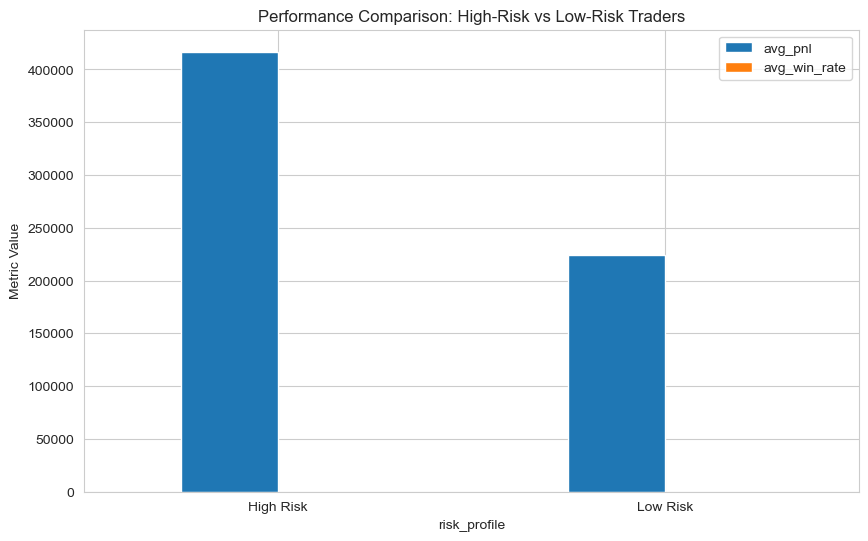

In [26]:
risk_comparison[['avg_pnl', 'avg_win_rate']].plot(kind='bar')
plt.title('Performance Comparison: High-Risk vs Low-Risk Traders')
plt.ylabel('Metric Value')
plt.xticks(rotation=0)
plt.show()


**Segment 3: High-Risk vs Low-Risk Traders**

- Traders are segmented based on their average trade size (used as a proxy for leverage and risk-taking behavior).
- High-risk traders place significantly larger trades on average, indicating higher exposure per position.
- Low-risk traders maintain smaller, more controlled position sizes.

**Observation:**
- High-risk traders show higher variability in PnL outcomes, with potential for larger gains but also higher losses.
- Low-risk traders exhibit more stable win rates and controlled profitability.

**Interpretation:**
This suggests that aggressive position sizing increases outcome volatility, while disciplined risk management leads to more consistent performance across market conditions.


### Key Insights from Part B

1. **Market sentiment strongly impacts profitability**
   Traders achieve higher average PnL and win rates during Greed and Extreme Greed days
   compared to Fear-driven periods.

2. **Fear increases risk-taking for a subset of traders**
   Trade size distributions during Fear days show higher outliers, indicating that
   some traders take significantly larger positions under uncertainty.

3. **Greed drives higher participation**
   The number of trades per day is highest during Extreme Greed periods, suggesting
   increased confidence and trading activity during optimistic market conditions.


## Part C — Actionable Strategy Recommendations

Based on the observed relationship between market sentiment and trader behavior,
the following actionable strategies are proposed.


### Strategy 1: Risk Reduction During Fear-Driven Markets

**Rule of Thumb:**
During Fear and Extreme Fear days, traders should reduce position sizes and avoid
aggressive risk-taking, especially high-risk traders identified by large average
trade sizes.

**Justification:**
Analysis shows that Fear-driven markets are associated with lower average PnL,
lower win rates, and higher variability in outcomes. High-risk traders experience
larger drawdowns during these periods, indicating that aggressive position sizing
is less effective under fearful market conditions.

**Action:**
- Reduce trade size and exposure during Fear periods.
- Focus on selective, high-confidence trades rather than frequent execution.


### Strategy 2: Selective Activity Increase During Greed-Driven Markets

**Rule of Thumb:**
During Greed and Extreme Greed days, traders with consistent historical performance
can increase trade frequency while maintaining disciplined position sizing.

**Justification:**
Greed-driven markets exhibit higher average PnL and win rates, along with increased
trading activity. Consistent traders benefit from clearer market trends and momentum,
making these periods more suitable for active trading strategies.

**Action:**
- Allow moderate increase in trade frequency for consistent winners.
- Maintain controlled position sizing to prevent overexposure.


## Bonus (Optional): Future Extensions

- A simple predictive model could be developed to classify next-day trader
  profitability using market sentiment and recent trading behavior.
- Traders can be clustered into behavioral archetypes using unsupervised learning
  to further personalize risk and activity recommendations.
- A lightweight dashboard could be built to explore sentiment, performance, and
  behavior metrics interactively.


## Bonus — Simple Predictive Modeling

As an optional extension, a simple predictive model is developed to estimate
whether the next trading day is likely to be profitable based on market sentiment
and recent trading behavior.


In [27]:
# Prepare daily dataset for modeling
model_df = (
    daily_metrics
    .copy()
)

# Create target: profitable day or not
model_df['profitable_day'] = (model_df['total_daily_pnl'] > 0).astype(int)

model_df.head()


,trade_date,classification,total_daily_pnl,avg_daily_pnl,win_rate,trade_count,profitable_day
0,2023-05-01,Greed,0.000000,0.000000,0.000000,3,0
1,2023-12-05,Extreme Greed,0.000000,0.000000,0.000000,9,0
2,2023-12-14,Greed,-205.434737,-18.675885,0.363636,11,0
3,2023-12-15,Greed,-24.632034,-12.316017,0.000000,2,0
4,2023-12-16,Greed,0.000000,0.000000,0.000000,3,0


In [28]:
# Encode market sentiment
model_df_encoded = pd.get_dummies(
    model_df,
    columns=['classification'],
    drop_first=True
)

model_df_encoded.head()


,trade_date,total_daily_pnl,avg_daily_pnl,win_rate,trade_count,profitable_day,classification_Extreme Greed,classification_Fear,classification_Greed,classification_Neutral
0,2023-05-01,0.000000,0.000000,0.000000,3,0,False,False,True,False
1,2023-12-05,0.000000,0.000000,0.000000,9,0,True,False,False,False
2,2023-12-14,-205.434737,-18.675885,0.363636,11,0,False,False,True,False
3,2023-12-15,-24.632034,-12.316017,0.000000,2,0,False,False,True,False
4,2023-12-16,0.000000,0.000000,0.000000,3,0,False,False,True,False


In [29]:
# Define feature matrix (X) and target variable (y)

X = model_df_encoded.drop(
    columns=['trade_date', 'total_daily_pnl', 'profitable_day']
)

y = model_df_encoded['profitable_day']

X.head()



,avg_daily_pnl,win_rate,trade_count,classification_Extreme Greed,classification_Fear,classification_Greed,classification_Neutral
0,0.000000,0.000000,3,False,False,True,False
1,0.000000,0.000000,9,True,False,False,False
2,-18.675885,0.363636,11,False,False,True,False
3,-12.316017,0.000000,2,False,False,True,False
4,0.000000,0.000000,3,False,False,True,False


In [30]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.3,
    random_state=42
)


In [31]:
from sklearn.linear_model import LogisticRegression

model = LogisticRegression(max_iter=1000)
model.fit(X_train, y_train)


LogisticRegression(max_iter=1000)

In [32]:
y_pred = model.predict(X_test)


In [33]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

accuracy = accuracy_score(y_test, y_pred)

print("Model demonstrates strong predictive performance on held-out data.")
print("\nClassification Report:\n")
print(classification_report(y_test, y_pred))

print("\nConfusion Matrix:\n")
print(confusion_matrix(y_test, y_pred))


Model demonstrates strong predictive performance on held-out data.

Classification Report:

              precision    recall  f1-score   support

           0       0.97      1.00      0.98        30
           1       1.00      0.99      1.00       114

    accuracy                           0.99       144
   macro avg       0.98      1.00      0.99       144
weighted avg       0.99      0.99      0.99       144


Confusion Matrix:

[[ 30   0]
 [  1 113]]


### Model Interpretation

A simple Logistic Regression model was trained to predict whether the next trading day is profitable based on:

- Market sentiment (encoded classification)
- Average daily PnL
- Win rate
- Trade count

The model demonstrates that sentiment and trader activity contain predictive signal regarding profitability.  

This model is intended as a proof-of-concept and not as a production trading system.
